Preparation of the dataset for the homemade backtest

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from numpy import int64
from matplotlib import pyplot as plt
import importlib
import joblib
from typing import List
from sqlalchemy.orm import sessionmaker

# Ensure project root is on sys.path for local imports
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "dataset_mngr").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if (PROJECT_ROOT / "dataset_mngr").exists():
    sys.path.insert(0, str(PROJECT_ROOT))

import backtest_portfolio as port
import backtest_preparation as prep
from dataset_mngr import db_models
from dataset_mngr import sqlite_io as sio
from dataset_mngr.db_models import Scenario as ScenarioORM, Campaign as CampaignORM, Strategy as StrategyORM, Model as ModelORM, Indicator as IndicatorORM,CombiModels as CombiModelsORM
from sqlalchemy.orm import Session

importlib.reload(port)
importlib.reload(prep)
importlib.reload(sio)
importlib.reload(db_models)


PATH_DATA = "D:\\Projets\\Data\\"
PATH_MODELS = PATH_DATA+"Models\\LGBM"
PATH_DB_FWK=PATH_DATA+"\\sqlite\\dataset_market.db"

if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

my_session_maker = sessionmaker(bind=con_fwk)
session=my_session_maker()

Create Model objects

In [2]:
TYPE_CLASS_5 = "Class 5"
TYPE_CLASS_10 = "Class 10"
SK_DATASET = 8
SK_SYMBOL = 417

list_models_conf = [
    {
        "id": 1,
        "name": "20D Adj class 5",
        "type": TYPE_CLASS_5,
        "label": "lab_perf_20d_class_5_adj",
        "label_base": "lab_perf_20d",
        "predict_col":"predict_5_adj",
        "proba_col": "predict_5_proba_adj",
        "filename": "PARIS_TREND_1D_ADJ_V5_class_R3_CLIP_20D_LGBM_MODEL_CLAS5_R3_2503_V1.pkl"
    },
    {
        "id": 2,
        "name": "20D Adj class 10",
        "type": TYPE_CLASS_10,
        "label": "lab_perf_20d_class_10_adj",
        "label_base": "lab_perf_20d",
        "predict_col":"predict_10_adj",
        "proba_col": "predict_10_proba_adj",
        "filename": "PARIS_TREND_1D_ADJ_V5_class_R3_CLIP_20D_LGBM_MODEL_CLAS10_R3_2503_V1.pkl"
    },
    {
        "id": 3,
        "name": "20D class 5",
        "type": TYPE_CLASS_5,
        "label": "lab_perf_20d_class5",
        "label_base": "lab_perf_20d",
        "predict_col":"predict_LGBM_CLASS_5_20D",
        "proba_col": "predict_LGBM_CLASS_5_20D_proba",
        "filename": "PARIS_TREND_1D_V5B_class_R3_CLIP_20D_LGBM_MODEL_CLAS5_R3_2507_V1.pkl"
    },
    {
        "id": 4,
        "name": "20D class 10",
        "type": TYPE_CLASS_10,
        "label": "lab_perf_20d_class10",
        "label_base": "lab_perf_20d",
        "predict_col":"predict_LGBM_CLASS_10_20D",
        "proba_col": "predict_LGBM_CLASS_10_20D_proba",
        "filename": "PARIS_TREND_1D_V5B_class_R3_CLIP_20D_LGBM_MODEL_CLAS10_R3_2507_V1.pkl"
    },
    {
        "id": 5,
        "name": "50D class 5",
        "type": TYPE_CLASS_5,
        "label": "lab_perf_50d_class5",
        "label_base": "lab_perf_50d",
        "predict_col":"predict_LGBM_CLASS_5_50D",
        "proba_col": "predict_LGBM_CLASS_5_50D_proba",
        "filename": "PARIS_TREND_1D_V5B_class_R3_CLIP_50D_LGBM_MODEL_CLAS5_R3_2508_V1.pkl"
    },
    {
        "id": 6,
        "name": "50D class 10",
        "type": TYPE_CLASS_10,
        "label": "lab_perf_50d_class10",
        "label_base": "lab_perf_50d",
        "predict_col":"predict_LGBM_CLASS_10_50D",
        "proba_col": "predict_LGBM_CLASS_10_50D_proba",
        "filename": "PARIS_TREND_1D_V5B_class_R3_CLIP_50D_LGBM_MODEL_CLAS10_R3_2507_V1.pkl"
    }
]

# for each model in list, open the file and add the feature list at the end
list_model=[]
list_labels=[]
list_predict_cols=[]
list_proba_cols=[]

for model in list_models_conf:
    mod_fic = joblib.load(PATH_MODELS + "\\" + model["filename"])
    model["features"] = mod_fic.booster_.feature_name()

    my_model=prep.Model(model["id"], model["name"], model["type"], model["label"],model["label_base"],
                        model["predict_col"], model["proba_col"], model["filename"], model["features"],
                        sk_dataset=SK_DATASET, sk_symbol=SK_SYMBOL)

    list_model.append(my_model)
    list_labels.append(model["label"])
    list_predict_cols.append(model["predict_col"])
    list_proba_cols.append(model["proba_col"])

    print(f"Model {my_model.name} loaded")

print(f"{list_model.__len__()} models loaded")


Model 20D Adj class 5 loaded
Model 20D Adj class 10 loaded
Model 20D class 5 loaded
Model 20D class 10 loaded
Model 50D class 5 loaded
Model 50D class 10 loaded
6 models loaded


d:\Projets\stockmarket-ml-toolkit\.env\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.1.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# save model in DB if doesn't exist, if exists get id

for model in list_model:
    # check if model exists
    model_orm = session.query(ModelORM).filter(ModelORM.name == model.name).first()
    if model_orm is None:
        indicator_orm = session.query(IndicatorORM).filter(IndicatorORM.label == model.label_base).first()
        if indicator_orm is None:
            raise ValueError(f"No IndicatorORM found with label '{model.label_base}'. Please ensure the indicator exists in the database.")
        model.sk_label = indicator_orm.sk_indicator
        sio.insert_object(session, ModelORM, model)
        session.commit()
        model_orm = session.query(ModelORM).filter(ModelORM.name == model.name).first()
        if model_orm is None:
            raise ValueError(f"Model '{model.name}' was not persisted; cannot set model id.")
        print(f"Model {model.name} added to DB with id {model_orm.sk_model}")
    else:
        print(f"Model {model.name} already exists in DB with id {model_orm.sk_model}")
    model.id = model_orm.sk_model


Model 20D Adj class 5 already exists in DB with id 21
Model 20D Adj class 10 already exists in DB with id 22
Model 20D class 5 already exists in DB with id 23
Model 20D class 10 already exists in DB with id 24
Model 50D class 5 already exists in DB with id 25
Model 50D class 10 already exists in DB with id 26


In [ ]:
list_strat_type=[]
my_strat_type_1 = prep.StrategyType(id=1, name="Strat 1", model_type="Class 5", description="1 modèle avec entrée à 4 sortie à 0")
list_strat_type.append(my_strat_type_1)

list_strat=[]

list_settings_strat = [
    {
        "id": 1,
        "type": TYPE_CLASS_5,
        "settings": {
            'entry_threshold': 4,
            'exit_threshold': 0
        }
    },
    {
        "id": 1,
        "type": TYPE_CLASS_10,
        "settings": {
            'entry_threshold': 8,
            'exit_threshold': 1
        }
    },
]

num_strat=1
# define entry_condition and exit_condition for the first strat
def entry_condition_1(df:pd.DataFrame, models:List[prep.Model], settings: dict ):
    return df[models[0].predict_col] >= settings.get('entry_threshold', 4)

def exit_condition_1(df:pd.DataFrame, models:List[prep.Model], settings: dict ):
    return df[models[0].predict_col] <= settings.get('exit_threshold', 0)

for n,strat_type in enumerate(list_strat_type):
    print(f"Strategy type {strat_type.name} loaded")
    for m in list_model:
       if m.type == strat_type.model_type:
           for s in list_settings_strat:
               if s["type"] == strat_type.model_type:
                   settings = s["settings"]
                   name=f"{strat_type.name}_{m.name}_{s['id']}".replace(" ","_")
                   my_strat=prep.Strategy(id=strat_type.calculate_id([m], num_strat,s['id']), name=name, type=strat_type,models=[m], 
                                  entry_condition=entry_condition_1, exit_condition=exit_condition_1, settings=settings)
           list_strat.append(my_strat)
           print(f"Strategy {my_strat.name} loaded")

print(f"{list_strat.__len__()} strategies loaded")

# insert strategies into DB if not exist
for strat in list_strat:
    existing_strat = session.query(StrategyORM).filter(StrategyORM.name == strat.name).first()
    if not existing_strat:
        sio.insert_object(session, StrategyORM,strat)
        strat_orm = session.query(StrategyORM).filter(StrategyORM.name == strat.name).first()
        strat.id = strat_orm.sk_strategy
        print(f"Inserted strategy {strat.name} into DB with id {strat.id}")
    else:
        strat.id = existing_strat.sk_strategy
        print(f"Strategy {strat.name} already exists in DB with id {strat.id}")

    list_combi_orm = sio.insert_combi(session, strat)
    for combi in list_combi_orm:
        print(f"  - link model to strategy {strat.name} (model {combi.sk_model}) to strategy {combi.sk_strategy}")


Strategy type Strat 1 loaded
Strategy Strat_1_20D_Adj_class_5_1 loaded
Strategy Strat_1_20D_class_5_1 loaded
Strategy Strat_1_50D_class_5_1 loaded
3 strategies loaded
Strategy Strat_1_20D_Adj_class_5_1 already exists in DB with id 1
  - link model to strategy Strat_1_20D_Adj_class_5_1 (model 21) to strategy 1
Strategy Strat_1_20D_class_5_1 already exists in DB with id 2
  - link model to strategy Strat_1_20D_class_5_1 (model 23) to strategy 2
Strategy Strat_1_50D_class_5_1 already exists in DB with id 3
  - link model to strategy Strat_1_50D_class_5_1 (model 25) to strategy 3


Load datasets

In [5]:
df=joblib.load(PATH_DATA+"\\DTS_FULL\\PARIS_TREND_1D_V5_5B_lab_20_adj_20_50_class_5_10_PREDICT_FULL_V2.pkl")
print(df.shape)

df = df[df['TRADABLE'] != 0]
print(df.shape)

default_val=-1
# fill na by default_val for cols in list_labels + list_predict_cols 
df[list_labels + list_predict_cols ] = df[list_labels + list_predict_cols ].fillna(default_val)


(1297807, 41)
(1297807, 41)


In [6]:
df['NAME']=df['NAME'].astype(str)
df['day'] = df.index.get_level_values(0)
df['weekday'] = df['day'].dt.weekday
df['week_YYYYWW']=df['day'].dt.strftime('%Y%W')
df['is_last_day_week'] = df.groupby('week_YYYYWW')['day'].transform(lambda x: x == x.max())
df['next_open'] = df.groupby('CODE')['OPEN'].shift(-1)
df['YYMM_int'] = (df['day'].dt.year-2000) * 12 + df['day'].dt.month

print(df.shape)

print(df['YYMM_int'].min(),df['YYMM_int'].max())

(1297807, 47)
-107 289


In [7]:
# for each strat add the entry and exit col
sort_column='cap_M'
sort_group_column='OPEN_DATETIME'

for strat in list_strat:
    df = strat.add_signals(df=df, sort_column=sort_column, sort_group_column=sort_group_column)

print(df.shape)
# print list of columns starting with 'entry_' or 'exit_'
print([col for col in df.columns if col.startswith('entry_') or col.startswith('exit_')])

print(df[df['lab_perf_20d_class_5_adj'].isna()].shape[0])

print(df.groupby(['lab_perf_20d_class_5_adj']).size())

(1297807, 56)
['entry_1000021011', 'exit_1000021011', 'entry_1000023011', 'exit_1000023011', 'entry_1000025011', 'exit_1000025011']
0
lab_perf_20d_class_5_adj
-1.0    626245
 0.0    146927
 1.0    132407
 2.0    128980
 3.0    131023
 4.0    132225
dtype: int64


In [8]:
# print the list of CODE where a month is missed between to values of YYMM_int
missing_dates_codes = []

# Group by CODE and check for gaps in YYMM_int
for code, group in df.groupby('CODE'):
    group = group.sort_values('YYMM_int')  # Sort by YYMM_int
    gaps = group['YYMM_int'].diff()  # Calculate differences between consecutive YYMM_int
    if (gaps > 1).any():  # Check if any gap is greater than 1
        missing_dates_codes.append(code)

# Print the list of codes with missing dates
print("Codes with missing dates in YYMM_int:", missing_dates_codes)

Codes with missing dates in YYMM_int: []


In [9]:
# scenario type 1 : fixe quantity scenario type 2 : variable quntity
pos_size=1000
sl=0.2

# def get_sl(df:pd.DataFrame,col:str, SL:float):
#     return df[col]*(1-SL)

list_scenarii_types=[
    {'max_positions': 10, 'position_size': pos_size,'sl':sl, 'scale_up': False, 'sell_all': True, 'fixe_quantity':False},
    {'max_positions': 10, 'position_size': pos_size,'sl':sl, 'scale_up': False, 'sell_all': True, 'fixe_quantity':True},
    {'max_positions': 5, 'position_size': pos_size*2,'sl':sl, 'scale_up': False, 'sell_all': True, 'fixe_quantity':True}
]

id_sce=0
list_scenarii=[]
for strat in list_strat:
    for sce_type in list_scenarii_types:
        id_sce+=1
        my_scenario=prep.Scenario(id=id_sce, strategy=strat, stop_loss='get_sl', params=sce_type)
        list_scenarii.append(my_scenario)
        # print(f"Scenario {my_scenario.id} - {my_scenario.strategy.name} - fixe_quantity={my_scenario.params['fixe_quantity']} loaded")

print(f"{list_scenarii.__len__()} scenarii loaded")

campaign_params={'initial_cash': 10000, 'parts':['TRAIN','VAL'],'commission': 0.003}
my_campaign=prep.Campaign(name="Campagne Test", description="Campagne test Paris TRAIN VAL",
                           scenarii=list_scenarii, params=campaign_params)

df_camp=df[df['PART'].isin(campaign_params['parts'])]#'TRAIN','VAL','CONF'
print(df_camp.shape)
# add date_start and date_end to my_campaign params
my_campaign.params['date_start'] = df_camp.index.get_level_values(0).min()
my_campaign.params['date_end'] = df_camp.index.get_level_values(0).max()
print(f"Campaign date range: {my_campaign.params['date_start']} to {my_campaign.params['date_end']}")

# save campaign in DB if not exist
existing_camp = session.query(CampaignORM).filter(CampaignORM.code == my_campaign.code).first()
if not existing_camp:
    sio.insert_object(session, CampaignORM,my_campaign)
    camp_orm = session.query(CampaignORM).filter(CampaignORM.code == my_campaign.code).first()
    my_campaign.id = camp_orm.sk_campaign
    print(f"Inserted campaign {my_campaign.name} into DB with id {my_campaign.id}")
else:
    my_campaign.id = existing_camp.sk_campaign
    print(f"Campaign {my_campaign.name} already exists in DB with id {my_campaign.id}")

#save scenarii in DB if not exist
for scenario in list_scenarii:
    print(f"1-{scenario.code=} {scenario.params=}")
    scenario.set_sk_campaign(my_campaign.id)
    print(f" 2 -{scenario.code=} {scenario.params=}")
    existing_sce = session.query(ScenarioORM).filter(ScenarioORM.code == scenario.code).first()
    if not existing_sce:
        sio.insert_object(session, ScenarioORM,scenario)
        sce_orm = session.query(ScenarioORM).filter(ScenarioORM.code == scenario.code).first()
        scenario.id = sce_orm.sk_scenario
        print(f"Inserted scenario for strategy {scenario.strategy.name} into DB with id {scenario.id}")
    else:
        scenario.id = existing_sce.sk_scenario
        print(f"Scenario for strategy {scenario.strategy.name} already exists in DB with id {scenario.id}")



9 scenarii loaded
(1059123, 56)
Campaign date range: 1991-01-03 00:00:00 to 2020-09-30 00:00:00
Campaign Campagne Test already exists in DB with id 1
1-scenario.code=None scenario.params={'max_positions': 10, 'position_size': 1000, 'sl': 0.2, 'scale_up': False, 'sell_all': True, 'fixe_quantity': False}
 2 -scenario.code='1_1_25d005a5f0' scenario.params={'max_positions': 10, 'position_size': 1000, 'sl': 0.2, 'scale_up': False, 'sell_all': True, 'fixe_quantity': False}
Scenario for strategy Strat_1_20D_Adj_class_5_1 already exists in DB with id 37
1-scenario.code=None scenario.params={'max_positions': 10, 'position_size': 1000, 'sl': 0.2, 'scale_up': False, 'sell_all': True, 'fixe_quantity': True}
 2 -scenario.code='1_1_cc2cc4cd77' scenario.params={'max_positions': 10, 'position_size': 1000, 'sl': 0.2, 'scale_up': False, 'sell_all': True, 'fixe_quantity': True}
Scenario for strategy Strat_1_20D_Adj_class_5_1 already exists in DB with id 38
1-scenario.code=None scenario.params={'max_posit

In [10]:

freq_print=20
log_to_file=True

dict_portfolio={}
for sce in my_campaign.scenarii:
    my_suffix=str(sce.strategy.suffix)
    entry_col='entry_'+my_suffix
    
    print(f"Scenario {sce.id} - {sce.strategy.name} - suffix={my_suffix} - fixe_quantity={sce.params['fixe_quantity']} loaded")

    # filter out rows where 'entry' is 0 and 'exit' is 0
    distinct_codes = df_camp[df_camp[entry_col] == 1].index.get_level_values('CODE').unique()
    codes_not_in_distinct = df_camp[~df_camp.index.get_level_values('CODE').isin(distinct_codes)].index.get_level_values('CODE').unique().tolist()
    print(f"{len(distinct_codes)=}-{len(codes_not_in_distinct)=}")

    df_clean = df_camp[~df_camp.index.get_level_values('CODE').isin(codes_not_in_distinct)]
    print(df_clean.shape)

    df_clean=sce.add_sl(df_clean, col='CLOSE', sl=sce.params['sl'])
    df_clean.loc[:,'quantity']=np.floor(sce.params['position_size']/df_clean['next_open'])

    df_bt=df_clean[['LOW','next_open','exit_'+my_suffix,'sl_'+my_suffix,'rank_'+my_suffix,entry_col,'quantity']]
    df_bt = df_bt.rename(columns={entry_col: 'entry','exit_'+my_suffix:'exit', 'next_open': 'price', 'LOW': 'low', 'sl_'+my_suffix: 'sl','rank_'+my_suffix:'priority'})
    print(df_bt.columns.tolist())
    print(df_bt.index.names)

    # backtest
    remaining_portfolio = port.backtest_strategy_portfolio(df_in=df_bt, initial_cash=my_campaign.params['initial_cash'],
                                                      commission=my_campaign.params['commission'],options=sce.params,
                                                      freq_print=freq_print, log_to_file=log_to_file)
    print(f'Remaining portfolio: {remaining_portfolio}')
    print(f'{remaining_portfolio.nb_trades= } {remaining_portfolio.total_commission= }')
    print(remaining_portfolio.metrics)
    dict_portfolio[sce.id] = remaining_portfolio

    # save result in DB
    try:
        # insert_bt_result(session: Session, sk_symbol: int, sk_scenario: int,
                    #  date_start:str, date_end:str, unit_time:str, log_file: str, extra: Optional[Dict[str, Any]] = None):

        bt_result_orm = sio.insert_bt_result(
            session=session,
            sk_symbol=SK_SYMBOL,
            sk_scenario=sce.id,
            date_start=str(my_campaign.params['date_start']),
            date_end=str(my_campaign.params['date_end']),
            unit_time='1D',
            log_file=remaining_portfolio.file_path,
            extra=remaining_portfolio.metrics
        )
        print(f"Inserted BT_RESULT for scenario {sce.id} into DB with id {bt_result_orm.sk_bt_result}")
    except Exception as e:
        print(f"Error inserting BT_RESULT for scenario {sce.id}: {e}")

    break


    # save the result
    # fic_res = PATH_DATA + f"BT_{my_portfolio.name}_{my_scenario.strategy.name}_FIXE_{my_scenario.params['fixe_quantity']}_V1.pkl".replace(" ","_")
    # joblib.dump(df_bt, fic_res)
    # print(f"Backtest result saved to {fic_res}")



Scenario 37 - Strat_1_20D_Adj_class_5_1 - suffix=1000021011 - fixe_quantity=False loaded
len(distinct_codes)=255-len(codes_not_in_distinct)=15
(1003144, 56)
['low', 'price', 'exit', 'sl', 'priority', 'entry', 'quantity']
['OPEN_DATETIME', 'CODE']
Logging to file: d:\Projets\stockmarket-ml-toolkit\backtest/logs/
Remaining portfolio: Portfolio: cash=201357.3, nb_positions=0, value=201357.3, positions= 
remaining_portfolio.nb_trades= 6684 remaining_portfolio.total_commission= np.float64(241314.75311249992)
{'final_value': np.float64(201357.30058750004), 'initial_cash': 10000, 'profit': np.float64(191357.30058750004), 'return_pct': np.float64(1913.5730058750003), 'max_drawdown_val': np.float64(148031.96797799997), 'max_drawdown_pct': np.float64(49.42059724310112), 'nb_sells': 3342, 'nb_trades': 6684, 'total_commission': np.float64(241314.75311249992), 'nb_wins': 1615, 'nb_losses': 1727, 'max_win_streak': 11, 'max_loss_streak': 20, 'win_rate': 0.4832435667265111, 'sharpe_ratio': np.float64(

{'final_value': np.float64(201357.30058750004), 'initial_cash': 10000, 'profit': np.float64(191357.30058750004), 'return_pct': np.float64(1913.5730058750003), 'max_drawdown_val': np.float64(148031.96797799997), 'max_drawdown_pct': np.float64(49.42059724310112), 'nb_sells': 3342, 'nb_trades': 6684, 'total_commission': np.float64(241314.75311249992), 'nb_wins': 1615, 'nb_losses': 1727, 'max_win_streak': 11, 'max_loss_streak': 20, 'win_rate': 0.4832435667265111, 'sharpe_ratio': np.float64(0.5006824166419619), 'calmar_ratio': np.float64(38.72015136648568), 'avg_trade_return': np.float64(57.258318548025144), 'profit_factor': np.float64(1.1870043250294702), 'avg_gain': np.float64(363.4454537332727), 'avg_risk': np.float64(2408.159239563135), 'risk_reward_win': np.float64(0.39562056318927386), 'risk_reward_loss': np.float64(-0.23708146557376575)}


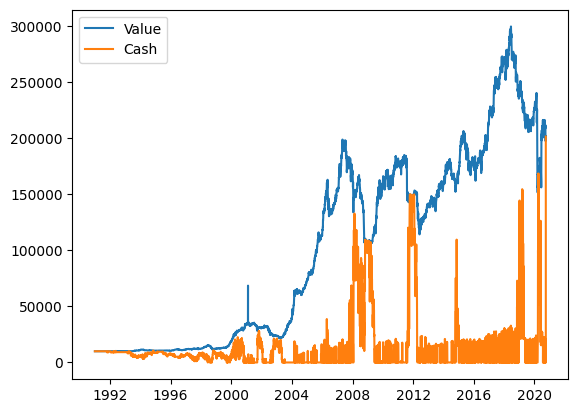

In [12]:

my_portfolio=dict_portfolio[list(dict_portfolio.keys())[0]]
# print metrics
print(my_portfolio.metrics)
# print graphic history of portfolio with matplotlib
plt.plot(my_portfolio.history['date'], my_portfolio.history['value'], label='Value')
plt.plot(my_portfolio.history['date'], my_portfolio.history['cash'], label='Cash')
# plt.plot(my_portfolio.history['date'], my_portfolio.history['value'] - my_portfolio.history['cash'], label='Invested')
plt.legend()
plt.show()


Scenarii generation

In [13]:
import json, hashlib
from itertools import product


def make_code(strategy_name: str, params: dict) -> str:
    s = json.dumps({"strategy": strategy_name, "params": params}, sort_keys=True, default=str)
    return hashlib.md5(s.encode()).hexdigest()[:12]


def generate_grid(base_strategy, param_grid: dict, start_id=1):
    keys = list(param_grid.keys())
    scenarios=[]
    id_counter = start_id
    for values in product(*[param_grid[k] for k in keys]):
        params = dict(zip(keys, values))
        code = make_code(base_strategy.name, params)
        sce = prep.Scenario(id=id_counter, strategy=base_strategy, stop_loss='get_sl', params=params)
        sce.code = code
        scenarios.append(sce)
        id_counter += 1
    return scenarios

## Grid generator + persistence + demo run
This section:
- Generates a small grid of scenarios for one existing strategy
- Persists (campaign + scenarios) to SQLite idempotently using your `sqlite_io` helpers
- Runs one scenario end-to-end and writes `BT_RESULT`

In [14]:
#  list strategies
list_strat_type=[]
my_strat_type_1 = prep.StrategyType(id=1, name="Strat 1", model_type="Class 5", description="1 modèle avec entrée à 4 sortie à 0")
list_strat_type.append(my_strat_type_1)

list_strat=[]

list_settings_strat = [
    {
        "id": 1,
        "type": TYPE_CLASS_5,
        "settings": {
            'entry_threshold': 4,
            'exit_threshold': 0
        }
    },
    {
        "id": 2,
        "type": TYPE_CLASS_5,
        "settings": {
            'entry_threshold': 4,
            'exit_threshold': 1
        }
    },
    {
        "id": 1,
        "type": TYPE_CLASS_10,
        "settings": {
            'entry_threshold': 8,
            'exit_threshold': 1
        }
    },
    {
        "id": 2,
        "type": TYPE_CLASS_10,
        "settings": {
            'entry_threshold': 8,
            'exit_threshold': 2
        }
    },
]

num_strat=1
# define entry_condition and exit_condition for the first strat
def entry_condition_1(df:pd.DataFrame, models:List[prep.Model], settings: dict ): #threshold:int=4
    return df[models[0].predict_col] >= settings.get('entry_threshold', 4)

def exit_condition_1(df:pd.DataFrame, models:List[prep.Model], settings: dict ):
    return df[models[0].predict_col] <= settings.get('exit_threshold', 0)

for n,strat_type in enumerate(list_strat_type):
    print(f"Strategy type {strat_type.name} loaded")
    for m in list_model:
       if m.type == strat_type.model_type:
           for s in list_settings_strat:
               if s["type"] == strat_type.model_type:
                   settings = s["settings"]
                   name=f"{strat_type.name}_{m.name}_{s['id']}".replace(" ","_")
                   my_strat=prep.Strategy(id=strat_type.calculate_id([m], num_strat,s['id']), name=name, type=strat_type,models=[m], 
                                  entry_condition=entry_condition_1, exit_condition=exit_condition_1, settings=settings)
           list_strat.append(my_strat)
           print(f"Strategy {my_strat.name} loaded")

print(f"{list_strat.__len__()} strategies loaded")

# insert strategies into DB if not exist
for strat in list_strat:
    existing_strat = session.query(StrategyORM).filter(StrategyORM.name == strat.name).first()
    if not existing_strat:
        sio.insert_object(session, StrategyORM,strat)
        strat_orm = session.query(StrategyORM).filter(StrategyORM.name == strat.name).first()
        strat.id = strat_orm.sk_strategy
        print(f"Inserted strategy {strat.name} into DB with id {strat.id}")
    else:
        strat.id = existing_strat.sk_strategy
        print(f"Strategy {strat.name} already exists in DB with id {strat.id}")

    list_combi_orm = sio.insert_combi(session, strat)
    for combi in list_combi_orm:
        print(f"  - link model to strategy {strat.name} (model {combi.sk_model}) to strategy {combi.sk_strategy}")


Strategy type Strat 1 loaded
Strategy Strat_1_20D_Adj_class_5_2 loaded
Strategy Strat_1_20D_class_5_2 loaded
Strategy Strat_1_50D_class_5_2 loaded
3 strategies loaded
Inserted strategy Strat_1_20D_Adj_class_5_2 into DB with id 4
  - link model to strategy Strat_1_20D_Adj_class_5_2 (model 21) to strategy 4
Inserted strategy Strat_1_20D_class_5_2 into DB with id 5
  - link model to strategy Strat_1_20D_class_5_2 (model 23) to strategy 5
Inserted strategy Strat_1_50D_class_5_2 into DB with id 6
  - link model to strategy Strat_1_50D_class_5_2 (model 25) to strategy 6


In [ ]:
# Pick one base strategy to generate scenarios for
if not list_strat:
    raise ValueError("list_strat is empty. Run the strategy creation cells first.")

base_strategy = list_strat[0]
print(f"Using base strategy: {base_strategy.name} (suffix={base_strategy.suffix})")

# Small grid (keep it small for demo)
param_grid = {
    "max_positions": [5, 10],
    "position_size": [1000, 2000],
    "sl": [0.15, 0.20],
    "scale_up": [False],
    "sell_all": [True],
    "fixe_quantity": [False, True],
}

# Generate scenarios (in-memory)
grid_scenarios = generate_grid(base_strategy=base_strategy, param_grid=param_grid, start_id=1)
print(f"Generated {len(grid_scenarios)} scenarios")
print("First 3 scenario params:")
for s in grid_scenarios[:3]:
    print(s.code, s.params)

In [ ]:
# --- Persist campaign + scenarios (idempotent) ---
campaign_params = {"initial_cash": 10000, "parts": ["TRAIN", "VAL"], "commission": 0.003}
grid_campaign = prep.Campaign(
    name="Campagne Grid Demo",
    description="Demo grid generation + persistence",
    scenarii=grid_scenarios,
    params=campaign_params,
)

# Ensure date range in campaign params (uses df already loaded in notebook)
df_camp = df[df["PART"].isin(grid_campaign.params["parts"])].copy()
grid_campaign.params["date_start"] = df_camp.index.get_level_values(0).min()
grid_campaign.params["date_end"] = df_camp.index.get_level_values(0).max()
print(f"Grid campaign date range: {grid_campaign.params['date_start']} -> {grid_campaign.params['date_end']}")

# Persist campaign
existing_camp = session.query(CampaignORM).filter(CampaignORM.code == grid_campaign.code).first()
if not existing_camp:
    sio.insert_object(session, CampaignORM, grid_campaign)
    existing_camp = session.query(CampaignORM).filter(CampaignORM.code == grid_campaign.code).first()
    print(f"Inserted campaign with id {existing_camp.sk_campaign}")
else:
    print(f"Campaign already exists with id {existing_camp.sk_campaign}")
grid_campaign.id = existing_camp.sk_campaign

# Ensure strategy exists + combi links exist
existing_strat = session.query(StrategyORM).filter(StrategyORM.name == base_strategy.name).first()
if not existing_strat:
    sio.insert_object(session, StrategyORM, base_strategy)
    existing_strat = session.query(StrategyORM).filter(StrategyORM.name == base_strategy.name).first()
base_strategy.id = existing_strat.sk_strategy
_ = sio.insert_combi(session, base_strategy)

# Persist scenarios (dedupe by code)
inserted = 0
already = 0
for scenario in grid_scenarios:
    scenario.set_sk_campaign(grid_campaign.id)
    existing_sce = session.query(ScenarioORM).filter(ScenarioORM.code == scenario.code).first()
    if existing_sce is None:
        sio.insert_object(session, ScenarioORM, scenario)
        existing_sce = session.query(ScenarioORM).filter(ScenarioORM.code == scenario.code).first()
        inserted += 1
    else:
        already += 1
    scenario.id = existing_sce.sk_scenario

print(f"Scenarios inserted={inserted}, already_present={already}")
print(f"Example persisted scenario id={grid_scenarios[0].id} code={grid_scenarios[0].code}")

In [ ]:
# --- Demo run: execute 1 scenario and write BT_RESULT ---
demo_sce = grid_scenarios[0]
suffix = str(demo_sce.strategy.suffix)
entry_col = "entry_" + suffix
exit_col = "exit_" + suffix
rank_col = "rank_" + suffix
sl_col = "sl_" + suffix

# Ensure signal columns exist (only add if missing)
if entry_col not in df.columns or exit_col not in df.columns:
    df = demo_sce.strategy.add_signals(df=df, sort_column="cap_M", sort_group_column="OPEN_DATETIME")

# Restrict to campaign parts
df_camp = df[df["PART"].isin(grid_campaign.params["parts"])].copy()

# Filter codes with at least 1 entry
distinct_codes = df_camp[df_camp[entry_col] == 1].index.get_level_values("CODE").unique()
df_clean = df_camp[df_camp.index.get_level_values("CODE").isin(distinct_codes)].copy()
print(f"df_clean shape: {df_clean.shape} (codes={len(distinct_codes)})")

# Add SL + quantity
df_clean = demo_sce.add_sl(df_clean, col="CLOSE", sl=demo_sce.params["sl"])
df_clean.loc[:, "quantity"] = np.floor(demo_sce.params["position_size"] / df_clean["next_open"])

df_bt = df_clean[["LOW", "next_open", exit_col, sl_col, rank_col, entry_col, "quantity"]].copy()
df_bt = df_bt.rename(
    columns={
        entry_col: "entry",
        exit_col: "exit",
        "next_open": "price",
        "LOW": "low",
        sl_col: "sl",
        rank_col: "priority",
    }
)

remaining_portfolio = port.backtest_strategy_portfolio(
    df_in=df_bt,
    initial_cash=grid_campaign.params["initial_cash"],
    commission=grid_campaign.params["commission"],
    options=demo_sce.params,
    freq_print=50,
    log_to_file=True,
)
print(remaining_portfolio.metrics)

bt_result_orm = sio.insert_bt_result(
    session=session,
    sk_symbol=SK_SYMBOL,
    sk_scenario=demo_sce.id,  # DB scenario id
    date_start=str(grid_campaign.params["date_start"]),
    date_end=str(grid_campaign.params["date_end"]),
    unit_time="1D",
    log_file=remaining_portfolio.file_path,
    extra=remaining_portfolio.metrics,
)
print(f"Inserted BT_RESULT for demo scenario {demo_sce.id} -> bt_result_id={bt_result_orm.sk_bt_result}")